# SYPA: Predicting Repetition & Dropout in Rwanda Primary Schools
## Quantitative Analysis
### Ben Brockman and Vincent Vanderputten - March 2017

This IPython notebook contains most quantitaive analysis for our MPAID SYPA (Second Year Policy Analysis)


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels
from statsmodels.regression.linear_model import OLS as OLS
from statsmodels.discrete.discrete_model import Logit as LOGIT
import statsmodels.api as sm
import statsmodels.tools.eval_measures as tools
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Funtion Definitions
### ==> Data processing and cleaning Functions

In [2]:
# start with a df and a threshold, return a correlation matrx and print out pairs that have correlation above threshold
def collinear_pairs(df, threshold = 0.95):
    df_simple = df.copy()
    corr_matp = df_simple.corr("pearson")
    k = 1
    for i in range(df_simple.shape[1]):
        for j in range(i):
            if corr_matp.iloc[i, j] > threshold:
                print "Pair", str(k)+")",  corr_matp.columns[j] , "\t|  ", corr_matp.columns[i],
                print "\t|  corr:" , np.round(corr_matp.iloc[i, j],5)
                k = k + 1
    if k==1:
        print "None found"
    return corr_matp

In [3]:
def power_cube(X_np):
    X_np_sq = np.power(X_np, 2)
    X_np_cube = np.power(X_np, 3)
    X_np_power = np.concatenate((X_np, X_np_sq), axis=1)
    X_np_power = np.concatenate((X_np_power, X_np_cube), axis=1)
    return X_np_power

In [4]:
## Define function that, given a varname, gets (or constructs) the corresponding label from dataframe:
def get_label_from_df(varname, predcat_df):
    returnlabel = ""
    ### FIRST: try to get the label directly (when varname is in dataframe)
    found_dummies = predcat_df['varname'].isin([varname])
    if np.sum(found_dummies)>0:
        single_line_df = predcat_df[found_dummies]
        returnlabel = single_line_df['label'].values[0]
        return returnlabel
    else:
        ### SECONDLY: try to get the label by de removing "_#" dummy extension (can be from a squared/cubed var or dummified one)
        split_varname_list = varname.split("_")
        new_varname = "_".join(split_varname_list[:-1]) # We just removed the extension after last "_" (including the "_" itself)
        found_dummies = predcat_df['varname'].isin([new_varname])
        if np.sum(found_dummies)>0:
            single_line_df = predcat_df[found_dummies]
            returnlabel = single_line_df['label'].values[0]
            return returnlabel
        else:
            ### THIRDLY: now should be only interaction vars left: get the two vars, get the two labels, and concatenate labels
            two_varname_list = varname.split("_x_")
            if len(two_varname_list)==2:
                # recursively call this function:
                returnlabel_1 = get_label_from_df(two_varname_list[0], predcat_df)
                returnlabel_2 = get_label_from_df(two_varname_list[1], predcat_df)
                returnlabel = "Interaction between ["+returnlabel_1+"] AND ["+returnlabel_2+"]"
                return returnlabel
            else:
                return "What the **** is going on?! This can't happen!"

In [5]:
## Define function that takes a list of (original) variable names and deletes them from the dataframe.
# (also deleted the "dummified" versions of any categorical variables as well as interactions)
# does not return anything, dataframe is edited "inplace".
def remove_varnames_from_df(varlist, df):
    # loop over all variables in the varlist of vars to remove
    for v in varlist:
        ### FIRST: try to remove the exact variable (when varname is in dataframe:
        if v in df.columns.values:
            df.drop([v], 1, inplace=True)
        
        # Loop over all varnames in df:
        for dfvar in df.columns.values:
            ### SECONDLY: try to remove the "_#" extension version of the variable
            ### (can be from a squared/cubed var or dummified one)
            split_varname_list = dfvar.split("_")
            original_varname = "_".join(split_varname_list[:-1]) # We removed extension after last "_" (including "_" itself)
            if v==original_varname:
                # remove dummy/square:
                df.drop([dfvar], 1, inplace=True)
            else:
                ### THIRDLY: now should be only interaction vars left to check:
                # get the two vars, check if 1 of 2 equals v, IF SO: remove.
                two_varname_list = dfvar.split("_x_")
                if len(two_varname_list)==2:
                    if v in two_varname_list:
                        # remove intereaction:
                        df.drop([dfvar], 1, inplace=True)
                    else:
                        # check if it was an interaction with a dummified categrocial dummy var
                        for var_x in two_varname_list:
                            split_varname_list = var_x.split("_")
                            if len(split_varname_list)>1:
                                original_varname = "_".join(split_varname_list[:-1]) # Removed extension after last "_"
                                if v==original_varname:
                                    df.drop([dfvar], 1, inplace=True)
                                    break

### ==> Lasso and Variable Selection Functions

In [6]:
def Log_w_Lasso(X_np, Y_np, start_C, end_C, num_loops):

    X_np = np.array(X_np, dtype=float)
    Y_np = np.array(Y_np, dtype=float)
    
    results = np.zeros([num_loops,2])

    C_vals = np.linspace(start_C, end_C, num=num_loops, endpoint=True)
    i = 0
    auc_best = 0
    for c in C_vals:

        X_np = X_np / X_np.std(axis=0)
        x_train, x_test, y_train, y_test = train_test_split(X_np, Y_np, test_size=0.3, random_state=158)

        #for models that require standardization
        x_train_std = x_train #/ x_train.std(axis = 0)
        x_test_std = x_test #/ x_train.std(axis = 0)

        model = LogisticRegression(penalty = 'l1', C = c) 
        model.fit(x_train_std, y_train)
        y_hat_probs = model.predict_proba(x_test_std)
        preds = y_hat_probs[:,1]
        fpr, tpr, threshold = roc_curve(y_test, preds)
        roc_auc = auc(fpr, tpr)
        
        # count how many covariates
        coefficients = model.coef_
        poscoef = coefficients> 1e-10 
        negcoef = coefficients< -1e-10 
        num_vars = np.sum(poscoef)
        num_vars_neg = np.sum(negcoef)
        totcoef = num_vars + num_vars_neg

        results[i, 0] = c
        results[i, 1] = roc_auc
        print "Loop" , i , "\t| C value:" , np.round(c,4) , "\t| AUC" , np.round(roc_auc,4) , "\t| Number of Variables: " , totcoef
        i += 1

        if roc_auc > auc_best:
            fpr_best = fpr
            tpr_best = tpr
            threshold_best = threshold
            auc_best = roc_auc
            c_best = c
        
    return fpr_best, tpr_best , threshold_best , auc_best , c_best , results


In [7]:
def plotROC(fpr_best, tpr_best, auc_best, title= 'Receiver Operating Characteristic' ):

    #Plot ROC with best AUC score
    plt.title(title)
    plt.plot(fpr_best, tpr_best, 'b', label = 'AUC = %0.4f' % auc_best)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [8]:
### Algorithm to find order of variables, as function of increasing C
def get_c_auc_coefdum_coefvars_coefvals(X_df, Y_df, num_vars_min=1, num_vars_max=10, num_vars_step=1, random=True,
                                        printflag=False, noprintatall=False):
    # convert DF to NP array
    X_np = np.array(X_df.values, dtype=float)
    Y_np = np.array(Y_df.values, dtype=float)
    # store variable names:
    varnames = X_df.columns.values
    
    if num_vars_step < 1: num_vars_steps = 1
    X_np = np.array(X_np, dtype=float)
    
    # Define functions to use inside this function:
    
    # give array of coefficients and get the number of nonzero ones:
    def get_num_nonzero_coeff(coefficients):
        # count how many non-negative coefficients
        num_vars_pos = np.sum( coefficients >  1e-10 )
        num_vars_neg = np.sum( coefficients < -1e-10 )
        return (num_vars_pos + num_vars_neg)
    
    # get the AUC of logistic model with lasso, I1 penalty and a given C:
    def get_auc_loglassomodel(c_in):
        model = LogisticRegression(penalty = 'l1', C = c_in) 
        model.fit(x_train_std, y_train)
        y_hat_probs = model.predict_proba(x_test_std)
        preds = y_hat_probs[:,1]
        fpr, tpr, threshold = roc_curve(y_test, preds)
        roc_auc = auc(fpr, tpr)
        return roc_auc, model
    
    # get the index of the newly added coefficient
    #def get_new_index(modelcoeff, currentindices):
        #TBD
    
    # Normalize data:
    X_np = X_np / X_np.std(axis=0)
    
    # split either randomly or give a seed
    if random:
        x_train, x_test, y_train, y_test = train_test_split(X_np, Y_np, test_size=0.3)
    else:
        x_train, x_test, y_train, y_test = train_test_split(X_np, Y_np, test_size=0.3, random_state=158)
    
    x_train_std = x_train
    x_test_std  = x_test
    
    # Array list of number of model variables
    num_vars = range(num_vars_min, num_vars_max+1, num_vars_step)
    
    #define arrays to popuplate:
    coef_dummies = np.zeros((len(num_vars), X_np.shape[1]))
    coef_values  = np.zeros((len(num_vars), X_np.shape[1]))
    c_values     = np.zeros(len(num_vars))
    auc_values   = np.zeros(len(num_vars))
    
    # get baseline: zero predictors (i=0):
#     c_temp = 0.000000001
#     c_values[0] = c_temp
#     auc_values[0], model_garbage = get_auc_loglassomodel(c_temp)
#     coef_dummies[0] = -1
    
    # set initial c_value:
    c_temp = 0
    
    # define jumps in c:
    if num_vars_min==num_vars_max:
        delta_c_up = 0.0002 * num_vars_min / 3.0 * 2.0
    else:
        delta_c_up = 0.0002 * num_vars_step
    
    # Loop: from a model with "num_vars_min" predictors to a model with "mun_vars_max" parameters:
    for i in range(len(num_vars)):
        goal = num_vars[i]
        if noprintatall==False: print "#vars =",goal,
        c_low  = c_temp
        c_temp = c_temp + delta_c_up
        
        # keep looping until the right number of coeff (i) is found:
        found = False
        while found==False:
            # try c_temp:
            auc_temp, model = get_auc_loglassomodel(c_temp)
            # count how many covariates
            num_nonzero_coeff = get_num_nonzero_coeff(model.coef_)
            if noprintatall==False: print ".",
            #print np.round(c_temp,3),
            
            # depending on the number of non-zero coefficients, do one of the following:
            
            if (num_nonzero_coeff < goal):
                # we need to increase c to get more coefficients (+1 ideally, to get i):
                c_low  = c_temp
                c_temp = c_temp + delta_c_up
            
            elif (num_nonzero_coeff > goal):
                # we need to decrease c to get less coefficients (ideally i):
                
                # By definition, a proper c-value is within interval [c_low, c_temp], so try the middle value:
                c_low  = c_low #same
                c_high = c_temp
                c_temp = (c_low + c_high) / 2
                
                # keep choosing the left or right interval until a proper c-value is found (one that gives 'i' non-zero coeff)
                while found==False:
                    # try c_temp + count how many covariates
                    auc_temp, model = get_auc_loglassomodel(c_temp)
                    num_nonzero_coeff = get_num_nonzero_coeff(model.coef_)
                    
                    #keep narrowing the interval:
                    if (num_nonzero_coeff < goal):
                        # we need to increase c to get more coefficients (+1 ideally, to get i):
                        # take middle of upper interval
                        c_low  = c_temp
                        c_high = c_high #same
                        c_temp = (c_low + c_high) / 2
                        if noprintatall==False: print "+",
                    elif (num_nonzero_coeff > goal):
                        # we need to decrease c to get less coefficients (ideally i):
                        # take middle of lower interval
                        c_low  = c_low #same
                        c_high = c_temp
                        c_temp = (c_low + c_high) / 2
                        if noprintatall==False: print "-",
                    else: # we found a good C, i.e. one that leads to 'goal' non-zero coefficients
                        found = True
                        
            else: # we found a good C, i.e. one that leads to 'goal' non-zero coefficients
                found = True
            
            if found==True:
                c_values[i] = c_temp
                auc_values[i] = auc_temp
                coef_values_all = model.coef_[0]
                coef_dummies[i] = (coef_values_all >  1e-10 ) + (coef_values_all < -1e-10)
                coef_values[i] = coef_values_all

                #get indices and print:
                nonzeroind = np.nonzero(coef_values_all)
                if noprintatall==False: print "FOUND: AUC =", np.round(auc_values[i],4), "   |   C =", np.round(c_values[i],4)
                coef_varnames = varnames[nonzeroind]
                coef_vals = coef_values_all[nonzeroind]
                if printflag:
                    #print coef_varnames
                    #print coef_values
                    for i,v in enumerate(coef_varnames):
                        print v,"=", np.round(coef_vals[i],4),
                        print " | LABEL:", get_label_from_df(v, predcat_df)
                    print "---"
    
    return c_values, auc_values, coef_dummies, coef_varnames, coef_values

### ==> Scorecard Functions

In [9]:
def get_auc_scorecard(x_test_df, y_test_df):
    coeff = ([])
    vars = ([])
    scores = np.zeros(len(x_test))
    for i in range(len(vars)):
        scores = scores + x_test_df[vars[i]].values * coeff[i]
    return scores

## Data Loading

In [10]:
### Get paths:
current_path = os.getcwd()
one_lower_path = "\\".join(current_path.split("\\")[:-1])

### Load full data
data = pd.read_csv((one_lower_path + "\\Data" + "\\eicv_4_v6_categories.csv"))

### Load predictor_categorization file:
predcat_df = pd.read_csv((one_lower_path + "\\Data" + "\\predictor_categorization.csv"))
predcat_df.head(5)

,varname,school_vs_ind,individual,remove_drop,teach_comm_prof,coll_cat,catvar_to_encode,baddum_to_encode,label
0,age_y,Individual,1,0,Teacher,1,0,0,age
1,district,School,0,0,Teacher,1,1,0,District
2,female,Individual,1,0,Teacher,1,0,0,female
3,hd_canread,Individual,1,0,Community,2,0,0,head of hh can read simple note
4,hd_disable,Individual,1,0,Community,2,0,0,head of hh is disabled


In [11]:
#df.drop(df.index[[1,3]])


## Data Processing and Cleaning

### ==> removing variables

In [12]:
## DROP PRIVATE school observations
print "Original data dimensions:",data.shape
nonprivate = data['type_priv'].values == 0
print "Number of non-private school pupils:", np.sum(nonprivate)
data1 = data[nonprivate]
print "Dimanesion with only public and subsidized schools", data1.shape
print "removed", np.sum(nonprivate==0),"private school pupils."


## Drop OTHER variables:
data1 = data1.drop(['type_subs', 'type_priv', 'freeschooling', 's1q4', 's1q5', 's1q6', 's2q4', 'poverty'], 1)
# note: poverty is a bad version of 'pov' dummy (3 values, not tru dummy)

Original data dimensions: (13945, 156)
Number of non-private school pupils: 13453
Dimanesion with only public and subsidized schools (13453, 156)
removed 492 private school pupils.


In [13]:
#Loop to check for 9's
for v in data1.columns.values:
    uniques = data1[v].unique()
    uniques = sorted(uniques)
    has9 = 9 in uniques
    shoterthan20 = len(uniques)<20
    if has9 & shoterthan20:
        #print v, "|", uniques
        whatever = 123

### ==> removing colinear variables (1/2)

In [14]:
## Find highly correlated variables (1/2)
df_corrmatrix = collinear_pairs(data, 0.95)

Pair 1) ln_costsboardtransp 	|   paid_trnsbrd 	|  corr: 0.97384
Pair 2) s1q8 	|   s1q9 	|  corr: 0.99999
Pair 3) s1q8 	|   s1q10 	|  corr: 0.99999
Pair 4) s1q9 	|   s1q10 	|  corr: 0.99999
Pair 5) s1q13 	|   s1q14 	|  corr: 0.99991
Pair 6) s2q2 	|   s2q4 	|  corr: 0.9998
Pair 7) s2q2 	|   s2q7 	|  corr: 0.99999
Pair 8) s2q4 	|   s2q7 	|  corr: 0.9998
Pair 9) s2q2 	|   s2q8 	|  corr: 1.0
Pair 10) s2q4 	|   s2q8 	|  corr: 0.9998
Pair 11) s2q7 	|   s2q8 	|  corr: 0.99999
Pair 12) schooltype 	|   s4aq9 	|  corr: 0.99998
Pair 13) schooltype 	|   s4aq13 	|  corr: 0.97123
Pair 14) s4aq9 	|   s4aq13 	|  corr: 0.97126
Pair 15) s4bq3 	|   s4bq5 	|  corr: 0.99609
Pair 16) s4bq3 	|   s4bq6 	|  corr: 0.99091
Pair 17) s4bq5 	|   s4bq6 	|  corr: 0.99153
Pair 18) s4bq3 	|   s4bq7 	|  corr: 0.99118
Pair 19) s4bq5 	|   s4bq7 	|  corr: 0.99178
Pair 20) s4bq6 	|   s4bq7 	|  corr: 0.99964
Pair 21) s4bq3 	|   s4bq8 	|  corr: 0.99028
Pair 22) s4bq5 	|   s4bq8 	|  corr: 0.99078
Pair 23) s4bq6 	|   s4bq8 	|  c

In [15]:
## Remove some collinear variables (1/2)
collin_todrop = ['kigali', 'ln_sol_jan', 'ln_exp12_wh', 'ln_exp14_1', 'ln_exp15_1', 'ln_exp16_1', 'hhsize_ae', 's6eq8', 's6eq10']
#...from the data:
data9 = data1.drop(collin_todrop, 1)
#...from the predictor categorization dataframe:
predcat_df = predcat_df[~predcat_df['varname'].isin(collin_todrop)]

# NOTE: s1q5 was removed based on the second rcorrelation check further down below.
print "Some perfect or highly correlated variables removed. Some remain:"
df_corrmatrix = collinear_pairs(data9, 0.95)

Some perfect or highly correlated variables removed. Some remain:
Pair 1) ln_costsboardtransp 	|   paid_trnsbrd 	|  corr: 0.97824
Pair 2) s1q8 	|   s1q9 	|  corr: 0.99999
Pair 3) s1q8 	|   s1q10 	|  corr: 0.99999
Pair 4) s1q9 	|   s1q10 	|  corr: 0.99999
Pair 5) s1q13 	|   s1q14 	|  corr: 0.99991
Pair 6) s2q2 	|   s2q7 	|  corr: 0.99999
Pair 7) s2q2 	|   s2q8 	|  corr: 1.0
Pair 8) s2q7 	|   s2q8 	|  corr: 0.99999
Pair 9) schooltype 	|   s4aq9 	|  corr: 0.99998
Pair 10) schooltype 	|   s4aq13 	|  corr: 0.97196
Pair 11) s4aq9 	|   s4aq13 	|  corr: 0.972
Pair 12) s4bq3 	|   s4bq5 	|  corr: 0.99591
Pair 13) s4bq3 	|   s4bq6 	|  corr: 0.99052
Pair 14) s4bq5 	|   s4bq6 	|  corr: 0.99115
Pair 15) s4bq3 	|   s4bq7 	|  corr: 0.99081
Pair 16) s4bq5 	|   s4bq7 	|  corr: 0.99143
Pair 17) s4bq6 	|   s4bq7 	|  corr: 0.99962
Pair 18) s4bq3 	|   s4bq8 	|  corr: 0.9899
Pair 19) s4bq5 	|   s4bq8 	|  corr: 0.99042
Pair 20) s4bq6 	|   s4bq8 	|  corr: 0.99787
Pair 21) s4bq7 	|   s4bq8 	|  corr: 0.99811
Pai

#### NOTE: many correlations remain due to the nature of the coding of "yes/no" questions: "missing" is "9" and many variables are missing, hence a strong correlation pops up...

### ==> Add variables:

In [16]:
# generate NEW dummies:
data9['upperprim'] = (data9['p4'].values + data9['p5'].values + data9['p6'].values) > 0
# re-enter 'p1': (ALRADY THERE!)
# data9['p1'] = (data9['p2'].values + data9['p3'].values + data9['p4'].values + data9['p5'].values + data9['p6'].values) == 0

### ==> Create 3 datasets: Three levels of data collection = teacher / community / professional

In [17]:
predcat_df.head(5)
#print predcat_df['varname'].values
#print predcat_df[[1]]


,varname,school_vs_ind,individual,remove_drop,teach_comm_prof,coll_cat,catvar_to_encode,baddum_to_encode,label
0,age_y,Individual,1,0,Teacher,1,0,0,age
1,district,School,0,0,Teacher,1,1,0,District
2,female,Individual,1,0,Teacher,1,0,0,female
3,hd_canread,Individual,1,0,Community,2,0,0,head of hh can read simple note
4,hd_disable,Individual,1,0,Community,2,0,0,head of hh is disabled


In [18]:
## All variables (for Repetition)
lvl1_vars = (predcat_df['varname'].values[predcat_df['coll_cat'].values == 1]).tolist() ##teacher
lvl2_vars = (predcat_df['varname'].values[predcat_df['coll_cat'].values <= 2]).tolist() ##community
lvl3_vars = (predcat_df['varname'].values[predcat_df['coll_cat'].values <= 3]).tolist() ##professional

### Subselection variables (for Dropout)

# vars not to be included in DROPOUT analysis:
todrop = (predcat_df['varname'].values[predcat_df['remove_drop'].values == 1]).tolist()
tokeep = (predcat_df['varname'].values[predcat_df['remove_drop'].values == 0]).tolist()
# only keep those vars that have not yet been removed earlier:
tokeep2= list(set(tokeep).intersection(data9.columns.values))

# remove and store in new varname lists:
lvl1_vars_drp = list(set(tokeep2).intersection(lvl1_vars))
lvl2_vars_drp = list(set(tokeep2).intersection(lvl2_vars))
lvl3_vars_drp = list(set(tokeep2).intersection(lvl3_vars))

# print "Teacher variables:", lvl1_vars
# print "---------------------"
# print "Community variables:", lvl2_vars
# print "---------------------"
# print "Professional variables:", lvl3_vars
# print "==========================================================="
# print "Variable to drop:", todrop
# print "---------------------"
# print "Teacher variables for Dropout:", lvl1_vars_drp
# print "---------------------"
# print "Community variables for Dropout:", lvl2_vars_drp
# print "---------------------"
# print "Professional variables for Dropout:", lvl3_vars_drp
# print "---------------------"
print "Done"

Done


In [19]:
### create limited-variabe dataframes:

# general (for REPETITION)
data_x1 = data9[lvl1_vars]
data_x2 = data9[lvl2_vars]
#data_x3 = data9[lvl3_vars] # Or:
data_x3 = data9.drop(['repeat', 'dropout'], 1)

# trimmed (for DROPOUT)
data_x1_drp = data9[lvl1_vars_drp]
data_x2_drp = data9[lvl2_vars_drp]
data_x3_drp = data9[lvl3_vars_drp]


In [20]:
# print data_x1.columns.values
# print data_x2.columns.values
# print data_x3.columns.values

In [21]:
print "data dimensions (x's):"
print data_x1.shape
print data_x2.shape
print data_x3.shape
print "data dimensions (dropout x's):"
print data_x1_drp.shape
print data_x2_drp.shape
print data_x3_drp.shape

data dimensions (x's):
(13453, 38)
(13453, 101)
(13453, 138)
data dimensions (dropout x's):
(13453, 26)
(13453, 58)
(13453, 81)


In [22]:
### SEE BELOW:
# ## ==> distort predictions for rep/prom classification
# data_test = data9.copy()
# print data_test.shape
# data_test = data_test.ix[data_test['dropout'] == 0]
# print data_test.shape



### ==> Encode categorical variables into dummies

In [23]:
#get y-values
y_df_rep = data9['repeat']
y_df_drp = data9['dropout']
y_np_rep = data9.values[:,0] # REPEAT is the FIRST column # OR: data_y.values
y_np_drp = data9.values[:,1] # DROPOUT is the SECOND column # OR: data_y.values

### IMPORTNAT !!!!!!!!!!!!!! FOR NOW, DROP the OBSERVATIONS for which DROPOUT==1. i.e. keep "non-dropouts"
nondropouts = y_np_drp == 0
data_x1 = data_x1.iloc[nondropouts,:]
data_x2 = data_x2.iloc[nondropouts,:]
data_x3 = data_x3.iloc[nondropouts,:]
y_df_rep = y_df_rep.iloc[nondropouts]
y_np_rep = y_np_rep[nondropouts]

#### ENCODE and create DUMMIES for the following variables:
def encode_categorical(data_in):
    #remove y-values from dataframe, keep only x-values:
    data_x = data_in.copy()
    if 'repeat' in data_in.columns:  data_x = data_x.drop(['repeat'], 1)
    if 'dropout' in data_in.columns: data_x = data_x.drop(['dropout'], 1)
    #print data_x.head()

    # Make dummies from categorical variables and from "bad dummies" (these are dummies with "missing=9, no=0, yes=1"):
    categoricals_to_encode = (predcat_df['varname'].values[predcat_df['catvar_to_encode'].values == 1]).tolist()
    bad_dummies_to_encode  = (predcat_df['varname'].values[predcat_df['baddum_to_encode'].values == 1]).tolist()
    to_encode = categoricals_to_encode + bad_dummies_to_encode
    
    # only take those "to encode" variables which are actually in the dataframe
    current_names = data_x.columns.values
    to_encode_for_real_this_time = list(set(current_names).intersection(to_encode))
    
    x_df_out = pd.get_dummies(data_x, columns = to_encode_for_real_this_time)
    #print data_with_dummies.columns.values
    print "Dimensions of dummified data (only X's, not Y):", x_df_out.shape
    print "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    
    #varnames = x_df_out.columns.values
    #x_np_out = np.array(x_df_out.values, dtype=float)
    #return varnames, x_df_out, x_np_out
    return x_df_out

# get X-varnames, dataframe, and numpy array; for each of the three levels of variables:
x1_df = encode_categorical(data_x1)
x2_df = encode_categorical(data_x2)
x3_df = encode_categorical(data_x3)
x1_df_drp = encode_categorical(data_x1_drp)
x2_df_drp = encode_categorical(data_x2_drp)
x3_df_drp = encode_categorical(data_x3_drp)

Dimensions of dummified data (only X's, not Y): (12576, 129)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Dimensions of dummified data (only X's, not Y): (12576, 340)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Dimensions of dummified data (only X's, not Y): (12576, 381)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Dimensions of dummified data (only X's, not Y): (13453, 96)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Dimensions of dummified data (only X's, not Y): (13453, 208)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Dimensions of dummified data (only X's, not Y): (13453, 235)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


### ==> remove many dummies of "empty" categoricals:

In [24]:
# don't remove these:
dontremove = ['s1q2_9', 's1q8_9', 's2q3m_9', 's2q7_9'] # '9' is a sensible catgory here, not just "empty", "other" or "missing".
# remove these:
toremove1 = ['s3q5_8', 's4aq10_8', 's6eq6_8', 's1q12_8', 's4aq12'] 
# loop over vars (in biggest dataframe, i.e. x3_df) and get ones with estnsion _9, _99 or _999
toremove2 = []
for v in x3_df.columns.values:
    if v in dontremove:
        # don't remove; no particular action
        whatever = 123
    elif (("_9" in v) | ("_99" in v) | ("_999" in v)):
        toremove2.append(v)

# all vars to remove:
toremove = toremove1 + toremove2

# loop over all dataframes and remove these "to remove" variables:
dfs = [x1_df, x2_df, x3_df, x1_df_drp, x2_df_drp, x3_df_drp]
print "pre-remove dimensions ||| after-remove dimensions"
for df in dfs:
    print df.shape,"---",
    # remove only those variables that are "toremove" *and* that are in the dataframe:
    toremovefinal = list(set(df.columns.values).intersection(toremove))
    # now drop those:
    df.drop(toremovefinal, 1, inplace=True)
    print df.shape

pre-remove dimensions ||| after-remove dimensions
(12576, 129) --- (12576, 109)
(12576, 340) --- (12576, 284)
(12576, 381) --- (12576, 325)
(13453, 96) --- (13453, 87)
(13453, 208) --- (13453, 185)
(13453, 235) --- (13453, 212)


In [25]:
print "Some perfect or highly correlated variables removed. Some remain:"
df_corrmatrix = collinear_pairs(x3_df, 0.95)

Some perfect or highly correlated variables removed. Some remain:
Pair 1) ln_costsboardtransp 	|   paid_trnsbrd 	|  corr: 0.97815
Pair 2) ln_exp16a_1 	|   ln_exp16a_2 	|  corr: 0.97074
Pair 3) ln_cons1_ae 	|   lncons_ae 	|  corr: 0.96319
Pair 4) ln_exp1 	|   ln_exp_edu_ae 	|  corr: 0.9825
Pair 5) paidtuition 	|   ln_coststutition 	|  corr: 0.97648
Pair 6) paid_contrib 	|   ln_costscontributions 	|  corr: 0.9687
Pair 7) paid_uniform 	|   ln_costsuniform 	|  corr: 0.98967
Pair 8) s6eq13_0 	|   s6eq7_0 	|  corr: 0.99236


### ==> Create higher order: squares and Interactions

In [26]:
## CREATE SQUARED terms
# For now, work with repetition variables only

x1_df_pow2 = x1_df.copy()
for v in x1_df.columns.values:
    # Only create higher order terms if it is not a dummy (i.e. more than two values, approximately)
    if len(x1_df[v].unique())>2:
        x1_df_pow2[v+"_pow2"] = np.power(x1_df[v].values,2)

x2_df_pow2 = x2_df.copy()
for v in x2_df.columns.values:
    # Only create higher order terms if it is not a dummy (i.e. more than two values, approximately)
    if len(x2_df[v].unique())>2:
        x2_df_pow2[v+"_pow2"] = np.power(x2_df[v].values,2)

x3_df_pow2 = x3_df.copy()
for v in x3_df.columns.values:
    # Only create higher order terms if it is not a dummy (i.e. more than two values, approximately)
    if len(x3_df[v].unique())>2:
        x3_df_pow2[v+"_pow2"] = np.power(x3_df[v].values,2)


## CREATE INTERACTIONS 
# interact these variables:
# vars_to_interact = (['ontrack', 'age_y', 'urb', 'female', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'pov', 'upperprim'])
# vars_to_interact = (['upperprim', 'female', 'ontrack', 'schooltype_3'])
vars_to_interact = []

# interact 1:
x1_df_pow2_interact = x1_df_pow2.copy()
for v1 in vars_to_interact:
    for v2 in x1_df_pow2: #_.columns.values ==> optional!
        if v1==v2:
            print '|',
        else: #do interaction
            newvarname = v1+'_x_'+v2
            x1_df_pow2_interact[newvarname] = x1_df_pow2_interact[v1].values * x1_df_pow2_interact[v2].values

# interact 2:
x2_df_pow2_interact = x2_df_pow2.copy()
for v1 in vars_to_interact:
    for v2 in x2_df_pow2: #_.columns.values ==> optional!
        if v1==v2:
            print '|',
        else: #do interaction
            newvarname = v1+'_x_'+v2
            x2_df_pow2_interact[newvarname] = x2_df_pow2_interact[v1].values * x2_df_pow2_interact[v2].values

# interact 3:
x3_df_pow2_interact = x3_df_pow2.copy()
for v1 in vars_to_interact:
    for v2 in x3_df_pow2: #_.columns.values ==> optional!
        if v1==v2:
            print '|',
        else: #do interaction
            newvarname = v1+'_x_'+v2
            x3_df_pow2_interact[newvarname] = x3_df_pow2_interact[v1].values * x3_df_pow2_interact[v2].values

            
## Remove variable that have only one value:
for df in [x1_df_pow2_interact, x2_df_pow2_interact, x3_df_pow2_interact]:
    listremove = []
    print "------------------------------"
    for i in range(df.shape[1]):
        if len(np.unique(df.iloc[:,i].values)) == 1:
            culprit = df.columns.values[i]
            print "Found! culprit = ", culprit
            listremove.append(culprit)
    df = df.drop(listremove, 1, inplace=True)

            
print ""
print "Level 1 ================================"       
print x1_df.shape
print x1_df_pow2.shape
print x1_df_pow2_interact.shape
print "Level 2 ================================"       
print x2_df.shape
print x2_df_pow2.shape
print x2_df_pow2_interact.shape
print "Level 3 ================================"       
print x3_df.shape
print x3_df_pow2.shape
print x3_df_pow2_interact.shape


------------------------------
------------------------------
------------------------------

Level 1 ================================
(12576, 109)
(12576, 113)
(12576, 113)
Level 2 ================================
(12576, 284)
(12576, 301)
(12576, 301)
Level 3 ================================
(12576, 325)
(12576, 376)
(12576, 376)


In [27]:
#### UPDATE varnames and NumPy Arrays:

def get_varnames_and_array(data_in):
    varnames = data_in.columns.values
    x_np_out = np.array(data_in.values, dtype=float)
    return varnames, x_np_out
    
# get X-varnames, dataframe, and numpy array; for each of the three levels of variables:
varnames_x1,     x1_np =     get_varnames_and_array(x1_df)
varnames_x2,     x2_np =     get_varnames_and_array(x2_df)
varnames_x3,     x3_np =     get_varnames_and_array(x3_df)
varnames_x1_pow2, x1_np_pow2 = get_varnames_and_array(x1_df_pow2)
varnames_x2_pow2, x2_np_pow2 = get_varnames_and_array(x2_df_pow2)
varnames_x3_pow2, x3_np_pow2 = get_varnames_and_array(x3_df_pow2)
varnames_x1_pow2_interact, x1_np_pow2_interact = get_varnames_and_array(x1_df_pow2_interact)
varnames_x2_pow2_interact, x2_np_pow2_interact = get_varnames_and_array(x2_df_pow2_interact)
varnames_x3_pow2_interact, x3_np_pow2_interact = get_varnames_and_array(x3_df_pow2_interact)
# for dropout:
varnames_x1_drp, x1_np_drp = get_varnames_and_array(x1_df_drp)
varnames_x2_drp, x2_np_drp = get_varnames_and_array(x2_df_drp)
varnames_x3_drp, x3_np_drp = get_varnames_and_array(x3_df_drp)

In [28]:
x2_df_pow2.head()

,age_y,female,hd_canread,hd_disable,hd_ed_lopr,hd_ed_lose,hd_ed_none,hd_ed_popr,hd_ed_uni,hd_ed_uppr,...,s4aq14_pow2,s6aq7a_pow2,s6aq7b_pow2,s6eq4_pow2,s6fq10_pow2,s6fq12_pow2,s6fq2_pow2,s6fq4_pow2,s6fq6_pow2,s6fq8_pow2
0,13,0,1,0,0,0,0,0,0,1,...,49,0,0,998001,0,0,1,0,0,0
1,9,1,1,0,0,0,0,0,0,1,...,49,0,0,998001,0,0,0,0,0,0
2,11,1,1,0,0,0,0,1,0,0,...,49,0,0,998001,0,0,0,0,0,1
3,12,0,1,0,0,0,0,1,0,0,...,49,0,0,998001,0,0,0,0,0,0
4,12,0,0,0,0,0,1,0,0,0,...,49,0,0,998001,0,0,0,0,0,0


## Variable Selection and Modelling

### ==> REPETITION: Run on all data; Three levels: 1=teacher / 2=community / 3=professional

REPETITION - LEVEL 1 data
(12576L, 109L)
(12576L,)
Loop 0 	| C value: 0.001 	| AUC 0.6694 	| Number of Variables:  3
Loop 1 	| C value: 0.0026 	| AUC 0.6748 	| Number of Variables:  5
Loop 2 	| C value: 0.0041 	| AUC 0.6775 	| Number of Variables:  7
Loop 3 	| C value: 0.0057 	| AUC 0.6938 	| Number of Variables:  15
Loop 4 	| C value: 0.0072 	| AUC 0.7005 	| Number of Variables:  20
Loop 5 	| C value: 0.0088 	| AUC 0.7051 	| Number of Variables:  27
Loop 6 	| C value: 0.0103 	| AUC 0.7094 	| Number of Variables:  36
Loop 7 	| C value: 0.0119 	| AUC 0.7125 	| Number of Variables:  37
Loop 8 	| C value: 0.0134 	| AUC 0.7145 	| Number of Variables:  39
Loop 9 	| C value: 0.015 	| AUC 0.7159 	| Number of Variables:  43


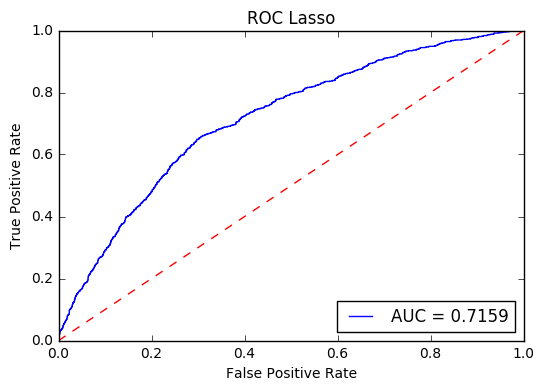

REPETITION - LEVEL 2 data
(12576L, 109L)
(12576L,)
Loop 0 	| C value: 0.001 	| AUC 0.6672 	| Number of Variables:  3
Loop 1 	| C value: 0.0026 	| AUC 0.6764 	| Number of Variables:  5
Loop 2 	| C value: 0.0041 	| AUC 0.6836 	| Number of Variables:  9
Loop 3 	| C value: 0.0057 	| AUC 0.6966 	| Number of Variables:  17
Loop 4 	| C value: 0.0072 	| AUC 0.704 	| Number of Variables:  22
Loop 5 	| C value: 0.0088 	| AUC 0.7082 	| Number of Variables:  31
Loop 6 	| C value: 0.0103 	| AUC 0.7116 	| Number of Variables:  42
Loop 7 	| C value: 0.0119 	| AUC 0.7148 	| Number of Variables:  53
Loop 8 	| C value: 0.0134 	| AUC 0.717 	| Number of Variables:  54
Loop 9 	| C value: 0.015 	| AUC 0.7188 	| Number of Variables:  61


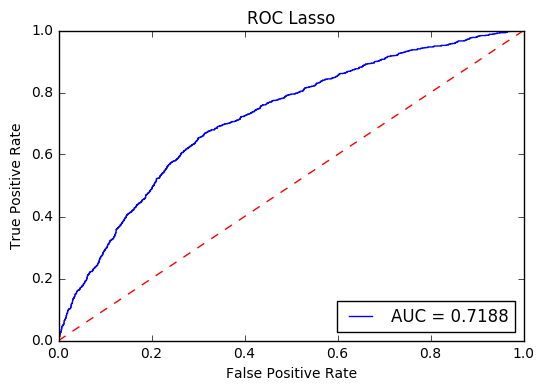

REPETITION - LEVEL 3 data
(12576L, 109L)
(12576L,)
Loop 0 	| C value: 0.001 	| AUC 0.6869 	| Number of Variables:  3
Loop 1 	| C value: 0.0026 	| AUC 0.6986 	| Number of Variables:  6
Loop 2 	| C value: 0.0041 	| AUC 0.7009 	| Number of Variables:  6
Loop 3 	| C value: 0.0057 	| AUC 0.7098 	| Number of Variables:  16
Loop 4 	| C value: 0.0072 	| AUC 0.7156 	| Number of Variables:  24
Loop 5 	| C value: 0.0088 	| AUC 0.7185 	| Number of Variables:  31
Loop 6 	| C value: 0.0103 	| AUC 0.7212 	| Number of Variables:  42
Loop 7 	| C value: 0.0119 	| AUC 0.7244 	| Number of Variables:  54
Loop 8 	| C value: 0.0134 	| AUC 0.7266 	| Number of Variables:  60
Loop 9 	| C value: 0.015 	| AUC 0.7282 	| Number of Variables:  68


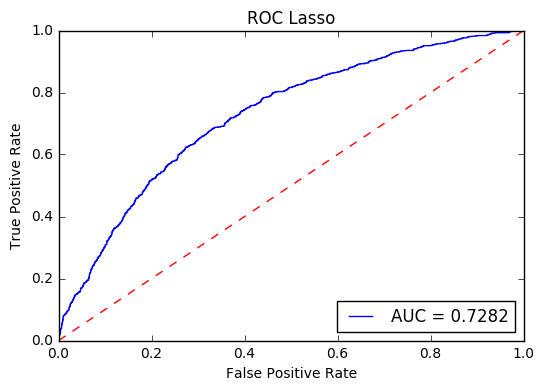

In [29]:
print "REPETITION - LEVEL 1 data"
print x1_np.shape
print y_np_rep.shape
fpr_best, tpr_best , threshold_best , auc_best , c_best , results = Log_w_Lasso(x1_np_pow2_interact, y_np_rep, .001, .015, 10)
plotROC(fpr_best, tpr_best, auc_best, title= 'ROC Lasso') 
print "REPETITION - LEVEL 2 data"
print x1_np.shape
print y_np_rep.shape
fpr_best, tpr_best , threshold_best , auc_best , c_best , results = Log_w_Lasso(x2_np_pow2_interact, y_np_rep, .001, .015, 10)
plotROC(fpr_best, tpr_best, auc_best, title= 'ROC Lasso') 
print "REPETITION - LEVEL 3 data"
print x1_np.shape
print y_np_rep.shape
fpr_best, tpr_best , threshold_best , auc_best , c_best , results = Log_w_Lasso(x3_np_pow2_interact, y_np_rep, .001, .015, 10)
plotROC(fpr_best, tpr_best, auc_best, title= 'ROC Lasso') 


In [30]:
x2_df_powint_indiv = x2_df_pow2_interact.copy()


## All variables (for Repetition)
school_vars = (predcat_df['varname'].values[predcat_df['individual'].values == 0]).tolist() ##school vars to remove
remove_varnames_from_df(school_vars, x2_df_powint_indiv)

# print x2_df_powint_indiv.columns.values


In [31]:
### Run model many times and see distribution of variables
df_to_use = x2_df_pow2_interact.copy()
num_splits = 50
num_vars = 20

aucs = np.zeros(num_splits)
coeff_indices = np.zeros(df_to_use.shape[1])
coeff_values_sum = np.zeros(df_to_use.shape[1])

for i in range(num_splits):
    print ".",
    c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(df_to_use, y_df_rep,
            num_vars_min= num_vars, num_vars_max=num_vars, num_vars_step=1, printflag=False, random=True, noprintatall=True)
    aucs[i] = auc_values[0]
    coeff_indices = coeff_indices + coef_dummies[0]
    coeff_values_sum = coeff_values_sum + coef_values[0]


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


HISTOGRAM for AUC values


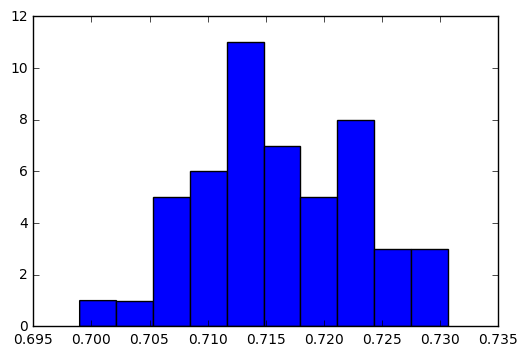

C:\Users\Vincent\Dropbox\git_repos\repetition-risk\Data\varselect_lvl2_v2b_noint.csv


,varname,coeff_freq,coeff_val_avg,label
0,s4bq5_1,50.0,-0.112602,Can perform a written calculation
1,s4bq4_1,50.0,-0.184242,Can write a letter or a simple note
2,s4bq3_1,50.0,-0.318464,Can read a letter or a simple note
3,district_34,50.0,0.067752,District
4,schooltype_1,49.0,-0.036478,public-1 or subsidized-3
5,age_y,49.0,-0.046914,age
6,paidtuition,48.0,-0.025811,paid any tuition
7,id1_4,48.0,-0.026946,Province
8,district_35,47.0,0.016935,District
9,s6fq1_0,46.0,-0.017076,Fetched water last 7 days


In [32]:
# subselection of the occuring variabels (non-zero frequency in model):
coeff_freq_nonzero = coeff_indices!=0
coeff_freq = coeff_indices[coeff_freq_nonzero]
varnames_nonzero = df_to_use.columns.values[coeff_freq_nonzero]
coeff_values_sum_nonzero = coeff_values_sum[coeff_freq_nonzero]
coeff_values_avg = coeff_values_sum_nonzero / coeff_freq

coeff_freq, varnames_nonzero, coeff_values_avg = (list(t) for t in zip(*sorted(zip(coeff_freq,
                                                                                   varnames_nonzero,
                                                                                   coeff_values_avg), reverse=True)))
# # transform to numpy:
# coeff_freq = np.array(coeff_freq)
# varnames_nonzero = np.array(varnames_nonzero)
# coeff_values_avg = np.array(coeff_values_avg)
# print coeff_freq.shape
# print varnames_nonzero.shape
# print coeff_values_avg.shape


print "HISTOGRAM for AUC values"
plt.hist(aucs)
plt.show()

#generate label list:
labellist = []
for i in range(len(varnames_nonzero)):
    labellist.append(get_label_from_df(varnames_nonzero[i], predcat_df))

df_out = pd.DataFrame(data = pd.Series(varnames_nonzero), columns = ['varname'])
df_out['coeff_freq'] = pd.Series(coeff_freq)
df_out['coeff_val_avg'] = pd.Series(coeff_values_avg)
df_out['label'] = pd.Series(labellist)

print (one_lower_path + "\\Data" + "\\varselect_lvl2_v2b_noint.csv")
df_out.to_csv(path_or_buf= one_lower_path + "\\Data" + "\\varselect_lvl2_v2b_noint.csv")
#sep=', ', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None,
# compression=None, quoting=None, quotechar='"', line_terminator='\n', chunksize=None, tupleize_cols=False, date_format=None,
# doublequote=True, escapechar=None, decimal='.')


df_out.head(30)

# print "Freq | varname | avg coeff. value | description"
# print "================================================"
# for i in range(len(coeff_freq)):
#     coeff = np.round(coeff_values_avg[i],4)
#     print coeff_freq[i]," | ",varnames_nonzero[i]," | ",coeff," | ",get_label_from_df(varnames_nonzero[i], predcat_df)


## SCORECARD creation

Dimensions = (12576, 26)
26 26
p1 	-0.6293 	in primary 1
p2 	-0.5495 	in primary 2
p3 	-0.0728 	in primary 3
p4 	0.23 	in primary 4
p5 	0.6562 	in primary 5
age_y 	-0.0503 	age
age_y_pow2 	-0.0016 	age
s6fq1_1 	0.5693 	Fetched water last 7 days
s4aq15_2 	0.3652 	Cause of not attending school
s4aq15_10 	0.8203 	Cause of not attending school
s4bq8_1 	-0.7071 	Has a mobile telephone
s6fq1_0 	0.2494 	Fetched water last 7 days
s6eq1_1 	-0.1214 	Worked for one hour in the last 7 dyas in S6A activities
s4aq15_5 	0.562 	Cause of not attending school
s6aq6_0 	-0.5456 	Worked in HH member non-farm business for no pay
s4bq3_1 	-0.7713 	Can read a letter or a simple note
s4bq4_1 	-0.7105 	Can write a letter or a simple note
s4bq5_1 	-0.3366 	Can perform a written calculation
district_33 	-0.6186 	District
district_34 	0.834 	District
district_35 	0.5603 	District
district_41 	-0.4898 	District
id1_2 	0.2022 	Province
id1_4 	-0.2131 	Province
schooltype_3 	0.1387 	public-1 or subsidized-3
paidtuiti

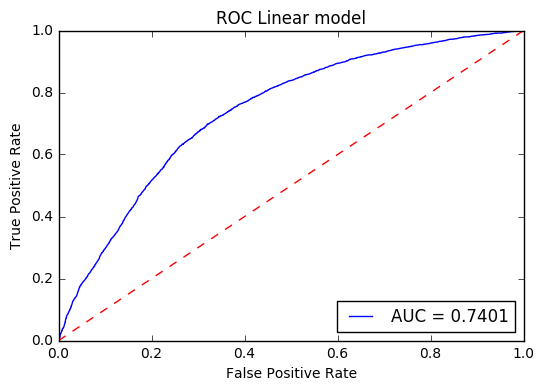

Optimization terminated successfully.
         Current function value: 0.504747
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 repeat   No. Observations:                12576
Model:                          Logit   Df Residuals:                    12549
Method:                           MLE   Df Model:                           26
Date:                Tue, 13 Jun 2017   Pseudo R-squ.:                  0.1228
Time:                        21:14:38   Log-Likelihood:                -6347.7
converged:                       True   LL-Null:                       -7236.1
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.8270      0.591      1.400      0.161        -0.331     1.985
p1              -0.6293

In [33]:
# Variables to keep:
scorecard_vars = ['p1', 'p2', 'p3', 'p4', 'p5', 'age_y', 'age_y_pow2', #'ontrack',
                  's6fq1_1', 's4aq15_2', 's4aq15_10', #'s4aq13_1', #'hd_mobile'
                  's4bq8_1', 's6fq1_0', 's6eq1_1', 's4aq15_5', 's6aq6_0', 's4bq3_1', 's4bq4_1', 's4bq5_1',
                  'district_33', 'district_34', 'district_35', 'district_41', 'id1_2', 'id1_4', 'schooltype_3',
                  'paidtuition']
# removed: 'hd_edulvl' s4aq13_1

x2_df_selection = x2_df_pow2_interact[scorecard_vars]
print "Dimensions =",x2_df_selection.shape

x_varnames = x2_df_selection.columns.values
X_np = x2_df_selection.values
Y_np = y_df_rep.values

#x_train, x_test, y_train, y_test = train_test_split(X_np, Y_np, test_size=0.3, random_state=40)
# x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(X_df, Y_df, test_size=0.3, random_state=40)
# x_train = x_train_df.values
# x_test = x_test_df.values
# y_train = y_train_df.values
# y_test = y_test_df.values


# USING SKLEARN
model = LogisticRegression(C=1e12, solver='newton-cg') 
#model = LinearRegression()
model.fit(X_np, Y_np)

#print scorecard_vars
coefficients = model.coef_[0] # don't take constant

print len(scorecard_vars), len(coefficients)
# Print coefficients
for i in range(len(scorecard_vars)):
    print scorecard_vars[i], "\t", np.round(coefficients[i],4), "\t", get_label_from_df(scorecard_vars[i], predcat_df)

Y_np_predicted = (model.predict_proba(X_np))[:,1]
#Y_np_predicted = (model.predict(X_np))
print Y_np_predicted
#preds = y_hat_probs[:,1]
fpr, tpr, threshold = roc_curve(Y_np, Y_np_predicted)
roc_auc = auc(fpr, tpr)
#plot
plotROC(fpr, tpr, roc_auc, title= 'ROC Linear model') 



# USING STATSMODEL
x2_df_selection = sm.add_constant(x2_df_selection)
logitmodel = sm.Logit(y_df_rep, x2_df_selection)
results = logitmodel.fit()
print results.summary()

# y_hat = logitmodel.predict(x2_df_selection)
# #preds = y_hat_probs[:,1]
# fpr, tpr, threshold = roc_curve(y_test_df, y_hat)
# roc_auc = auc(fpr, tpr)
# #plot
# plotROC(fpr, tpr, roc_auc, title= 'ROC Linear model') 


### Calculate "manual" scorecard:


In [34]:
def create_scorecard_predictions(x_df):
    y_pred_scorecard = np.zeros(x_df.shape[0])
    for i in range(x_df.shape[0]):
        score = 0
        # Grade and age factors
        grade_age = np.array([[8, 8, 7, 6, 5, 4, 3, 3, 2, 1, 0],
                              [9, 8, 8, 7, 6, 5, 4, 3, 3, 2, 1],
                              [14, 13, 12, 12, 11, 10, 9, 8, 7, 7, 6],
                              [17, 16, 15, 15, 14, 13, 12, 11, 10, 9, 9],
                              [21, 20, 20, 19, 18, 17, 16, 15, 15, 14, 13],
                              [15, 14, 13, 12, 11, 10, 10, 9, 8, 7, 6]])
        row = x_df['prim_grade'].values[i] - 1
        col = x_df['age_y'].values[i] - 6
        if col>10: col = 10
        score += grade_age[row,col]
        
        # mobile phone
        if x_df['s4bq8_1'].values[i]==0: score += 7
        
        # fecthed water
        if x_df['s6fq1_1'].values[i]==1: score += 3
        
        # missed days?
        if x_df['s4aq15_2'].values[i]==1: score += 4
        if x_df['s4aq15_5'].values[i]==1: score += 6
        
        # child worked?
        if x_df['s6eq1_1'].values[i]==0: score += 1
        if x_df['s6aq6_0'].values[i]==0: score += 5
            
        # academic?
        if x_df['s4bq3_1'].values[i]==0: score += 8
        if x_df['s4bq4_1'].values[i]==0: score += 7
        if x_df['s4bq5_1'].values[i]==0: score += 3
        
        # paid any tuition?
        if x_df['paidtuition'].values[i]==0: score += 6
        
        # regional
#         if x_df['district_33'].values[i]==1: score += (-6)
#         if x_df['district_34'].values[i]==1: score += 8
#         if x_df['district_35'].values[i]==1: score += 6
#         if x_df['district_41'].values[i]==1: score += (-5)
#         if x_df['id1_2'].values[i]==1: score += 2
#         if x_df['id1_4'].values[i]==1: score += (-2)
#         if x_df['schooltype_3'].values[i]==1: score += 1
        
        y_pred_scorecard[i] = score
        
    return y_pred_scorecard
                

y_pred_sc = create_scorecard_predictions(x2_df_pow2_interact)
                



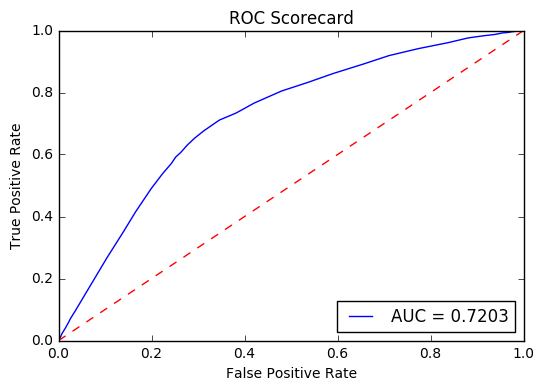

In [35]:
fpr, tpr, threshold = roc_curve(y_df_rep.values, y_pred_sc)
roc_auc = auc(fpr, tpr)

plotROC(fpr, tpr, roc_auc, title= 'ROC Scorecard') 

In [36]:
## Base data (no power or interactions)
c_values, auc_values_1, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x1_df_pow2_interact, y_df_rep,
                                                                num_vars_min=0, num_vars_max=50, printflag=False, random=False)
## Base data (no power or interactions)
c_values, auc_values_2, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x2_df_pow2_interact, y_df_rep,
                                                                num_vars_min=0, num_vars_max=50, printflag=False, random=False)
## Base data (no power or interactions)
c_values, auc_values_3, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x3_df_pow2_interact, y_df_rep,
                                                                num_vars_min=0, num_vars_max=50, printflag=False, random=False)

#vars = 0 . - FOUND: AUC = 0.5    |   C = 0.0
#vars = 1 . FOUND: AUC = 0.498    |   C = 0.0002
#vars = 2 . . FOUND: AUC = 0.6222    |   C = 0.0006
#vars = 3 . FOUND: AUC = 0.6651    |   C = 0.0008
#vars = 4 . FOUND: AUC = 0.6702    |   C = 0.001
#vars = 5 . FOUND: AUC = 0.6725    |   C = 0.0012
#vars = 6 . . . . . . . . . . . . . . FOUND: AUC = 0.6767    |   C = 0.004
#vars = 7 . FOUND: AUC = 0.6781    |   C = 0.0042
#vars = 8 . . + FOUND: AUC = 0.6821    |   C = 0.0045
#vars = 9 . FOUND: AUC = 0.6851    |   C = 0.0047
#vars = 10 . FOUND: AUC = 0.686    |   C = 0.0048
#vars = 11 . FOUND: AUC = 0.6868    |   C = 0.0049
#vars = 12 . FOUND: AUC = 0.6875    |   C = 0.005
#vars = 13 . FOUND: AUC = 0.6899    |   C = 0.0052
#vars = 14 . FOUND: AUC = 0.6915    |   C = 0.0054
#vars = 15 . . FOUND: AUC = 0.6946    |   C = 0.0058
#vars = 16 . FOUND: AUC = 0.6955    |   C = 0.006
#vars = 17 . . . FOUND: AUC = 0.6972    |   C = 0.0066
#vars = 18 . - FOUND: AUC = 0.6974    |   C = 0.0066
#vars = 19 

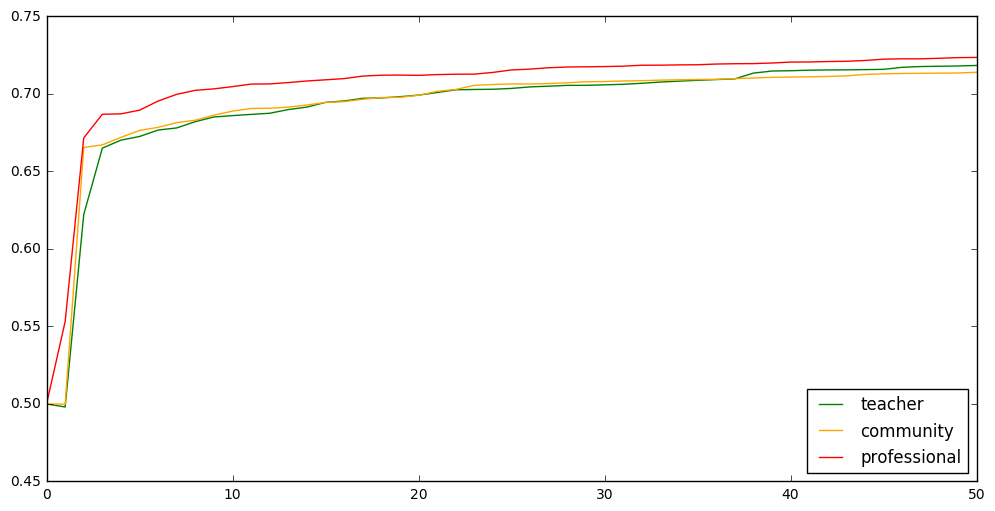

In [37]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.plot(auc_values_1, color='green', label='teacher')
ax1.plot(auc_values_2, c='orange', label='community')
ax1.plot(auc_values_3, c='red', label='professional')
plt.legend(loc='lower right')
plt.show()

# Appendix: extra analysis

### ==> Finding most important / most predictive variables using Lasso

### REPETITION

In [38]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x1_df, y_df_rep,
                                                                num_vars_min=0, num_vars_max=20, printflag=True, random=False)

#vars = 0 . - FOUND: AUC = 0.5    |   C = 0.0
---
#vars = 1 . FOUND: AUC = 0.498    |   C = 0.0002
s3q2_1 = -0.0914  | LABEL: Suffers from a major disability
---
#vars = 2 . . FOUND: AUC = 0.6222    |   C = 0.0006
age_y = -0.0568  | LABEL: age
s3q2_1 = -0.0852  | LABEL: Suffers from a major disability
---
#vars = 3 . FOUND: AUC = 0.6651    |   C = 0.0008
age_y = -0.0876  | LABEL: age
s4bq3_1 = -0.1044  | LABEL: Can read a letter or a simple note
s3q2_1 = -0.0582  | LABEL: Suffers from a major disability
---
#vars = 4 . FOUND: AUC = 0.6705    |   C = 0.001
age_y = -0.0884  | LABEL: age
s4bq4_1 = -0.0175  | LABEL: Can write a letter or a simple note
s4bq3_1 = -0.1884  | LABEL: Can read a letter or a simple note
s3q2_1 = -0.0448  | LABEL: Suffers from a major disability
---
#vars = 5 . FOUND: AUC = 0.6725    |   C = 0.0012
age_y = -0.0847  | LABEL: age
s4bq5_1 = -0.0189  | LABEL: Can perform a written calculation
s4bq4_1 = -0.0549  | LABEL: Can write a letter or a simple note
s4bq3_1 = -0

In [39]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x1_df, y_df_rep,
                                                                num_vars_min=10, num_vars_max=10, printflag=True, random=True)

#vars = 10 . . . . . - FOUND: AUC = 0.7047    |   C = 0.0057
age_y = -0.049  | LABEL: age
paidtuition = -0.0015  | LABEL: paid any tuition
s6fq1_0 = -0.0072  | LABEL: Fetched water last 7 days
schooltype_1 = -0.0566  | LABEL: public-1 or subsidized-3
district_34 = 0.0311  | LABEL: District
district_35 = 0.0075  | LABEL: District
s4bq5_1 = -0.1284  | LABEL: Can perform a written calculation
s4bq4_1 = -0.222  | LABEL: Can write a letter or a simple note
s4bq3_1 = -0.2603  | LABEL: Can read a letter or a simple note
s3q2_1 = -0.0081  | LABEL: Suffers from a major disability
---


In [40]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x1_df, y_df_rep,
                                                                num_vars_min=20, num_vars_max=20, printflag=True, random=True)

#vars = 20 . . . FOUND: AUC = 0.7169    |   C = 0.008
age_y = -0.0576  | LABEL: age
hd_mobile = -0.0156  | LABEL: head of hh hass mobile phone
ontrack = 0.0322  | LABEL: pupil is on track
p2 = -0.0242  | LABEL: in primary 2
p5 = 0.0302  | LABEL: in primary 5
paidtuition = -0.0498  | LABEL: paid any tuition
urb = -0.0208  | LABEL: urban area
s6fq3_0 = -0.0041  | LABEL: Foraged for firewood last 7 days
s6fq1_0 = -0.032  | LABEL: Fetched water last 7 days
schooltype_1 = -0.0561  | LABEL: public-1 or subsidized-3
district_31 = 0.0026  | LABEL: District
district_33 = -0.0213  | LABEL: District
district_34 = 0.0748  | LABEL: District
district_35 = 0.0236  | LABEL: District
district_41 = -0.0218  | LABEL: District
s4bq5_1 = -0.0979  | LABEL: Can perform a written calculation
s4bq4_1 = -0.2184  | LABEL: Can write a letter or a simple note
s4bq3_1 = -0.3098  | LABEL: Can read a letter or a simple note
id1_2 = 0.013  | LABEL: Province
id1_4 = -0.0644  | LABEL: Province
---


In [41]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x2_df, y_df_rep,
                                                                num_vars_min=20, num_vars_max=20, printflag=True, random=True)

#vars = 20 . . . + + FOUND: AUC = 0.7224    |   C = 0.0077
age_y = -0.056  | LABEL: age
hd_edulvl = -0.0433  | LABEL: head of hh education level - 1 to 8 blocks
ontrack = 0.004  | LABEL: pupil is on track
p5 = 0.0176  | LABEL: in primary 5
paidtuition = -0.0345  | LABEL: paid any tuition
schooltype_1 = -0.0553  | LABEL: public-1 or subsidized-3
s6aq8_6 = 0.0056  | LABEL: Main reason for not working (last 12 months)
s6fq1_0 = -0.0111  | LABEL: Fetched water last 7 days
district_25 = 0.0024  | LABEL: District
district_28 = 0.0134  | LABEL: District
district_33 = -0.0119  | LABEL: District
district_34 = 0.0809  | LABEL: District
district_35 = 0.0134  | LABEL: District
district_41 = -0.0011  | LABEL: District
s4bq5_1 = -0.1257  | LABEL: Can perform a written calculation
s4bq4_1 = -0.2067  | LABEL: Can write a letter or a simple note
id1_2 = 0.0167  | LABEL: Province
id1_4 = -0.036  | LABEL: Province
s4bq3_1 = -0.2982  | LABEL: Can read a letter or a simple note
s4aq15_5 = 0.0125  | LABEL: 

In [42]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x3_df, y_df_rep,
                                                                num_vars_min=30, num_vars_max=30, printflag=True, random=True)

#vars = 30 . . . - + FOUND: AUC = 0.7424    |   C = 0.0095
totalcosts = -0.0773  | LABEL: costs of all school expenses
ln_exp16a_1 = 0.0572  | LABEL: Own non-food consumption with filter question 0 (log)
ln_exp_edu_ae = -0.1289  | LABEL: log of per adult equiv. education expenses
ontrack = 0.0719  | LABEL: pupil is on track
female = -0.0258  | LABEL: female
p2 = -0.0089  | LABEL: in primary 2
p5 = 0.0427  | LABEL: in primary 5
hd_edulvl = -0.012  | LABEL: head of hh education level - 1 to 8 blocks
quintile_5 = -0.007  | LABEL: income quintile
schooltype_3 = 0.0444  | LABEL: public-1 or subsidized-3
s6aq8_6 = 0.0573  | LABEL: Main reason for not working (last 12 months)
s6fq1_1 = 0.0011  | LABEL: Fetched water last 7 days
district_25 = 0.0025  | LABEL: District
district_33 = -0.0398  | LABEL: District
district_34 = 0.086  | LABEL: District
district_35 = 0.0415  | LABEL: District
district_41 = -0.0043  | LABEL: District
district_51 = -0.0096  | LABEL: District
s4bq8_1 = -0.0114  | LABEL:

In [43]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x3_df, y_df_rep,
                                                                num_vars_min=0, num_vars_max=50, printflag=False, random=True)

#vars = 0 . - - - FOUND: AUC = 0.5    |   C = 0.0
#vars = 1 . FOUND: AUC = 0.5423    |   C = 0.0002
#vars = 2 . FOUND: AUC = 0.5564    |   C = 0.0004
#vars = 3 . . . FOUND: AUC = 0.7015    |   C = 0.001
#vars = 4 . FOUND: AUC = 0.7033    |   C = 0.0012
#vars = 5 . FOUND: AUC = 0.7034    |   C = 0.0014
#vars = 6 . . . . FOUND: AUC = 0.7126    |   C = 0.0022
#vars = 7 . . . . . . . . . . FOUND: AUC = 0.7143    |   C = 0.0042
#vars = 8 . FOUND: AUC = 0.7149    |   C = 0.0043
#vars = 9 . - + - - + + + FOUND: AUC = 0.7157    |   C = 0.0044
#vars = 10 . FOUND: AUC = 0.7176    |   C = 0.0046
#vars = 11 . FOUND: AUC = 0.7184    |   C = 0.0047
#vars = 12 . FOUND: AUC = 0.7194    |   C = 0.0049
#vars = 13 . + + FOUND: AUC = 0.7201    |   C = 0.005
#vars = 14 . FOUND: AUC = 0.7207    |   C = 0.0052
#vars = 15 . . FOUND: AUC = 0.7218    |   C = 0.0055
#vars = 16 . FOUND: AUC = 0.7225    |   C = 0.0056
#vars = 17 . FOUND: AUC = 0.7235    |   C = 0.0058
#vars = 18 . FOUND: AUC = 0.7244    |   C = 0.

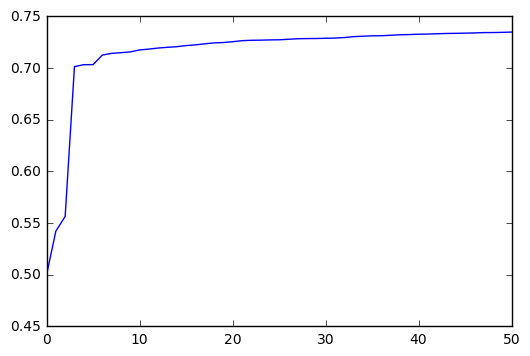

In [44]:
plt.plot(auc_values)
plt.show()

In [45]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x2_df, y_df_rep,
                                                                num_vars_min=0, num_vars_max=40, printflag=False, random=True)

#vars = 0 . - - FOUND: AUC = 0.5    |   C = 0.0
#vars = 1 . FOUND: AUC = 0.5006    |   C = 0.0002
#vars = 2 . . . FOUND: AUC = 0.6771    |   C = 0.0008
#vars = 3 . FOUND: AUC = 0.6794    |   C = 0.001
#vars = 4 . . FOUND: AUC = 0.6839    |   C = 0.0014
#vars = 5 . . FOUND: AUC = 0.6867    |   C = 0.0018
#vars = 6 . . . . . . . . . . . FOUND: AUC = 0.6881    |   C = 0.004
#vars = 7 . FOUND: AUC = 0.6911    |   C = 0.0042
#vars = 8 . FOUND: AUC = 0.696    |   C = 0.0043
#vars = 9 . FOUND: AUC = 0.7025    |   C = 0.0045
#vars = 10 . . . FOUND: AUC = 0.7103    |   C = 0.0051
#vars = 11 . FOUND: AUC = 0.7126    |   C = 0.0053
#vars = 12 . FOUND: AUC = 0.7142    |   C = 0.0055
#vars = 13 . FOUND: AUC = 0.7162    |   C = 0.0057
#vars = 14 . FOUND: AUC = 0.7169    |   C = 0.0058
#vars = 15 . - FOUND: AUC = 0.7173    |   C = 0.0059
#vars = 16 . FOUND: AUC = 0.7196    |   C = 0.0061
#vars = 17 . FOUND: AUC = 0.7219    |   C = 0.0063
#vars = 18 . FOUND: AUC = 0.7234    |   C = 0.0065
#vars = 19 .

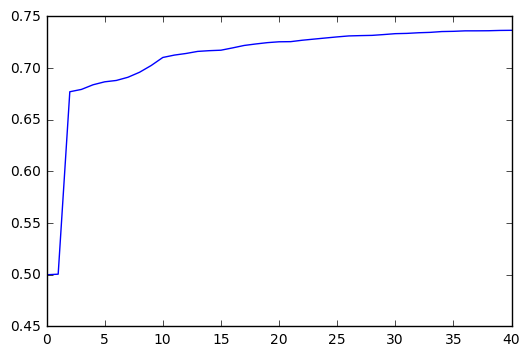

In [46]:
plt.plot(auc_values)
plt.show()

### DROPOUT

In [47]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x1_df_drp, y_df_drp,
                                                                num_vars_min=10, num_vars_max=10, printflag=True, random=True)

#vars = 10 . . . . . - FOUND: AUC = 0.8286    |   C = 0.0057
age_y = 0.0322  | LABEL: age
hhsize = -0.1558  | LABEL: household size
hd_mobile = -0.0113  | LABEL: head of hh hass mobile phone
upperprim = 0.1255  | LABEL: Pupil is in upper primary dummy
p6 = 0.1713  | LABEL: in primary 6
ontrack = -0.3776  | LABEL: pupil is on track
s4bq8_1 = 0.1939  | LABEL: Has a mobile telephone
s1q2_12 = 0.1656  | LABEL: Relation with head of household
s1q14_1 = -0.1449  | LABEL: Mother still alive
s3q2_1 = -0.2503  | LABEL: Suffers from a major disability
---


In [48]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x2_df_drp, y_df_drp,
                                                                num_vars_min=20, num_vars_max=20, printflag=True, random=True)

#vars = 20 . . . FOUND: AUC = 0.8434    |   C = 0.008
age_y = 0.0831  | LABEL: age
s2q2 = -0.139  | LABEL: Always lived in the district
ubudehe_123 = -0.0005  | LABEL: ubudehe category 1 or 2 or 3
hhsize = -0.1569  | LABEL: household size
hd_mobile = -0.1407  | LABEL: head of hh hass mobile phone
p6 = 0.2113  | LABEL: in primary 6
ontrack = -0.4581  | LABEL: pupil is on track
upperprim = 0.139  | LABEL: Pupil is in upper primary dummy
s1q14_1 = -0.0969  | LABEL: Mother still alive
s4bq8_0 = -0.0388  | LABEL: Has a mobile telephone
s4bq8_1 = 0.1558  | LABEL: Has a mobile telephone
s3q3_2 = -0.0472  | LABEL: Main health insurance
s3q2_1 = -0.2221  | LABEL: Suffers from a major disability
s3q2_4 = -0.0203  | LABEL: Suffers from a major disability
s3q2_5 = -0.0128  | LABEL: Suffers from a major disability
s1q9_2 = 0.0738  | LABEL: Reason for absence
s1q9_3 = 0.056  | LABEL: Reason for absence
s1q2_1 = 0.0083  | LABEL: Relation with head of household
s1q2_2 = 0.0344  | LABEL: Relation with 

In [49]:
## Base data (no power or interactions)
c_values, auc_values, coef_dummies, coef_varnames, coef_values = get_c_auc_coefdum_coefvars_coefvals(x3_df_drp, y_df_drp,
                                                                num_vars_min=30, num_vars_max=30, printflag=True, random=True)

#vars = 30 . . . . + - FOUND: AUC = 0.8928    |   C = 0.0145
age_y = 0.9823  | LABEL: age
ln_exp9 = 0.0275  | LABEL: In-kind payments  (log)
ln_exp4 = -0.0468  | LABEL: Imputed rents (log)
ln_cons1 = -0.3466  | LABEL: aggregate consumption (log)
hd_mobile = -0.0196  | LABEL: head of hh hass mobile phone
s2q6 = 0.0169  | LABEL: Duration of stay in the previous location (years)
lncons_ae = -0.0175  | LABEL: ln aggregate consumption / ae Jan14 = 100
p6 = 0.1135  | LABEL: in primary 6
upperprim = 0.0743  | LABEL: Pupil is in upper primary dummy
s1q10_1 = 0.0012  | LABEL: Lived in another HH during absence
s1q14_3 = 0.0414  | LABEL: Mother still alive
s2q7_2 = 0.0179  | LABEL: Primary reason for moving
s2q7_12 = 0.0241  | LABEL: Primary reason for moving
district_53 = 0.021  | LABEL: District
s4bq8_1 = 0.1461  | LABEL: Has a mobile telephone
s4bq5_0 = 0.0839  | LABEL: Can perform a written calculation
s4bq4_1 = -0.1474  | LABEL: Can write a letter or a simple note
s2q8_1 = 0.029  | LABEL: M